# Holoscope

In this example we show how to build the holoscope - a 3D lightfield microscope introduced in [FourierNets enable the design of highly non-local optical encoders for computational imaging](https://arxiv.org/abs/2104.10611). It's long been known that a rotating point spread fuction can be used to retrieve depth information (see for example Goodman chapter 8.2). The PSF compresses the 3D lightfield into a 2D image, but the optimal PSF is sample-dependent. The holoscope consists of 4f system with a SLM in the fourier plane to create a flexible and controllable PSF. We then use ML to optimize this phasemask, making the holoscope an efficient 3D snapshot microscope.



In [1]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn
import numpy as np
import matplotlib.pyplot as plt

from chromatix import Field, PSFImager
from chromatix.elements import ObjectivePointsource, PhaseMask, FFLens
from chromatix.ops.noise import shot_noise
from chromatix.ops.ops import downsample
from chromatix.ops.windows import sigmoid_taper
from chromatix.utils import center_crop


from typing import Callable, Optional
from chex import Array

key = random.PRNGKey(42)

%config InlineBackend.figure_format='retina'


The holoscope simulates the PSF at a higher resolution and FOV than the camera, so before applying the psf to the data we need to crop, downsample and apply a taper to the PSF. As an example, we'll walk through every step separately, and show at the end how to combine all of this nicely in a new model. 

First, some parameters:

In [2]:
# Parameters
camera_shape: tuple[int, int] = (512, 512)
camera_pixel_pitch: float = 0.325
f: float = 100
NA: float = 0.8
n: float = 1.33
wavelength: float = 0.532
wavelength_ratio: float = 1.0
upsample: int = 2
pad: int = 512
taper_width: Optional[float] = 5
noise_fn: Callable = shot_noise

First we calculate the spacing and size of the simulation based on the camera parameters:

In [3]:
shape = tuple(np.array(camera_shape) * upsample + pad)
spacing = upsample* f * wavelength/ (n * shape[0] * camera_pixel_pitch)

print(f"Shape of simulation: {shape}")
print(f"Spacing of simulation: {spacing:.2f}")

Shape of simulation: (1536, 1536)
Spacing of simulation: 0.16


We construct the 4f system out of a so-called `ObjectivePointsource`, which returns the field caused by a pointsource a distance $z$ from the focal distance before the lens (i.e. $z + f$ distance to the lens), at the focal point after the lens. A thing to note is that the `ObjectivePointsource` takes in this distance `z` at runtime. We can thus get the field and PSF at any distance we want, and when we give in a vector of distances the planes get placed along the batch axis of the field. In other words, the batch axis acts as the depth axis of the field in this example. 

In the focal plane of the first lens we place the SLM, represented here by just a phasemask, and follow it by an ff lens:

In [4]:
system = [ObjectivePointsource(shape, spacing, wavelength, wavelength_ratio, f, n, NA),
          PhaseMask(random.normal), # random init for the phasemask.
          FFLens(f, n)]

model = PSFImager(system, noise_fn=noise_fn, reduce_fn=lambda x: jnp.sum(x, axis=0, keepdims=True))
params = model.init({"params": key, "noise": key}, z=jnp.zeros((5, )), method=model.psf) # zeros is just for shape inference

Finally, as a noise model we add shotnoise (whose gradient is approximated by a Gaussian with $\sigma = \sqrt{N}$) and the `reduce_fn` sums over all the images in the batch as they form a 3D field.

As we perform the simulation on a higher resolution, we need to do some-postprocessing of the PSF to get it to the same resolution as the camera:

In [5]:
def post_process_psf(psf: Array) -> Array:
    psf = center_crop(psf, (None, pad // 2, pad // 2, None))
    psf = downsample(psf, (upsample, upsample))
    return psf * sigmoid_taper(camera_shape, taper_width)

To generate the image, we then simply get the PSF, post-process it and image:

In [6]:
@jax.jit
def generate_image(params, z, data):
    # We get the downsampled psf
    psf = model.apply(params, z, method=model.psf, rngs={"noise": key})
    psf = post_process_psf(psf)

    # And image with that
    return model.apply(params, psf, data, method=model.image, rngs={"noise": key}) # need rngs for reproducible noise.

In [7]:
# Some fake data, we sample the lightfield 5 times in the depth dimension
z = jnp.linspace(-150, 150, 5)
data = random.normal(key, (z.size, *camera_shape, 1))
image = generate_image(params, z, data)

print(image.shape)


(1, 512, 512, 1)


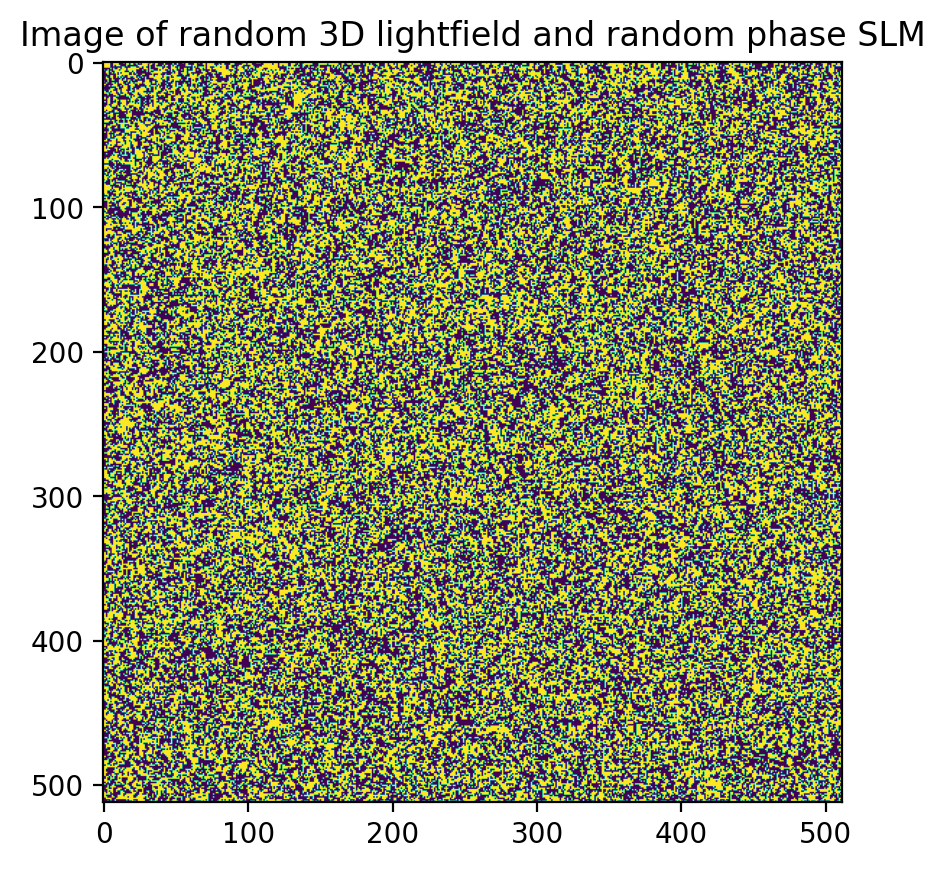

In [8]:
plt.title("Image of random 3D lightfield and random phase SLM")
plt.imshow(image.squeeze())

## Holoscope as a new model

In practice we would wrap this all up a new model, which is much simpler and cleaner. It would look like this:


In [9]:
class Holoscope(nn.Module):
    camera_shape: tuple[int, int] = (512, 512)
    camera_pixel_pitch: float = 0.325
    f: float = 100
    NA: float = 0.8
    n: float = 1.33
    wavelength: float = 0.532
    wavelength_ratio: float = 1.0
    upsample: int = 2
    pad: int = 512
    taper_width: Optional[float] = None

    noise_fn: Callable = shot_noise

    def setup(self):
        # Getting shapes and spacing right
        assert isinstance(self.upsample, int), "Upsample factor must be integer."
        assert isinstance(self.pad, int), "Padding must be integer."
        shape = tuple(np.array(self.camera_shape) * self.upsample + self.pad)
        # Spacing in SLM plane should be upsample * f * wavelength / (n * N_field * camera_spacing)
        spacing = (
            self.upsample
            * self.f
            * self.wavelength
            / (self.n * shape[0] * self.camera_pixel_pitch)
        )

        self.model = PSFImager(
            [
                ObjectivePointsource(
                    shape,
                    spacing,
                    self.wavelength,
                    self.wavelength_ratio,
                    self.f,
                    self.n,
                    self.NA,
                ),
                PhaseMask(random.normal),
                FFLens(self.f, self.n),
            ],
            noise_fn=self.noise_fn,
            reduce_fn=lambda x: jnp.sum(x, axis=0, keepdims=True),
        )
        if self.taper_width is not None:
            self.taper = sigmoid_taper(self.camera_shape, self.taper_width)

    def __call__(self, data: Array, z: Array):
        # Post processing of psf
        psf = self.psf(z, post_process=True)
        return self.model.image(psf, data)

    def psf(self, z: Array, post_process: bool = True) -> Array:
        psf = self.model.psf(z)
        if post_process:
            psf = center_crop(psf, (None, self.pad // 2, self.pad // 2, None))
            psf = downsample(psf, (self.upsample, self.upsample))
            if self.taper_width is not None:
                psf = psf * self.taper
        return psf

    def output_field(self, z: Array) -> Field:
        return self.model.output_field(z)

This model is more easy to handle, giving access to the (unprocessed) psf and the image, for example:

In [10]:
model = Holoscope()
params = model.init({"params": key, "noise": key}, data, z)

In [11]:
print(model.apply(params, z, post_process=False, method=model.psf).shape) # high res psf at each z
print(model.apply(params, z, post_process=True, method=model.psf).shape) # low res psf at each z
print(model.apply(params, data, z, rngs={"noise": key}).shape) # image

(5, 1536, 1536, 1)
(5, 512, 512, 1)
(1, 512, 512, 1)


This model can then be combined with a [Fourier](https://github.com/TuragaLab/fouriernet/tree/jax) to fully differentiably learn and reconstruct a 3D volume. 